# **NYC Property Sales Predictor (PSP) Modelling**

## **Goal**
For this entire project, I'm going to build a machine learning model that could predict the property sales price for properties in NYC. I'm dividing my project into the following sections:

* **EDA**
* **Data Preparation**
* **Modelling**

## **Project description**
In this document, I'm showing my modelling part for this project. For this project I'm going to use multiple algorithms:
*   Linear Regression
*   Random Forest 
*   XGBoost

Because I'm still working on this project, I'm using in this document only one algorithm: the Random Forest. Later on, I'm going to make this document more complete with more steps to finish this project. That is also the reason that the test data will not be used and the models only get evaluated on the validation data.




## **Importing Libraries**

In [1]:
import pandas as pd # Data manipulation
import numpy as np # Scientific computing
from numpy import percentile # For IQR

import matplotlib.pyplot as plt # Data Visualization
import seaborn as sns # Data Visualization

sns.set(style='darkgrid', context='notebook', palette='deep') # Theme
import matplotlib.style as style
style.use('fivethirtyeight') # Theme
import warnings; warnings.simplefilter('ignore') # Ignore warnings

## **Importing Data**
For this project I'm using my data set that I prepared in the data preparation section.

In [2]:
merged = pd.read_csv('data/merged_nyc_dataset.csv')

# **Machine Learning Part**
As I described above, I'm not including multiple algorithms and things as hyperparameter tuning. I'm going to create 2 models and compare them. I'm using the same algorithm for both models(the Random Forest) but the difference between these 2 models is that I'm feeding my second model improved data where I applied feature engineering to see what the impact from feature engineering was on my models predicting performance.

This is what my modelling part looks like so far:

1. **Modelling**
2. **Predictions and evaluation**
3. **Feature Engineering**
4. **Compare results**



## **1. Modelling**
For the modelling part, I'm going to use pipelines. Pipelines are a simple way to keep your preprocessing and modelling code organized. Specifically, a pipeline bundles preprocessing and modeling steps so you can use the whole bundle as if it were a single step. 

These are the steps that I'm taking for building a machine learning model:
* Splitting the data
* Filling the numerical missing values
* Using OneHotEncoding to transform the categorical features into numerical values
* Using ColumnTransformer to bundle the different preprocessing steps
* Instantiate a model
* Bundle the preprocessing and model code in a pipeline






### **Preprocessing the data**
Before I'm creating a ML pipeline, I'm dividing the data into train, validation en test. I'm using the **train** data to train the machine learning model, evaluate the model on the **validation** data and improving it before I'm feeding it the **test** data it hasn't seen before.
I will divide my data into the following sections:

*   **70% for training**
*   **15% for evaluation**
*   **15% for testing**


In [3]:
# Importing libraries
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Creating a copy of the  merged dataframe
copy = merged.copy()
# Splitting the data into X &y
X = copy.drop(['ADDRESS', 'SALE PRICE'], axis=1) # Dropping some irrelevant columns and the target
y = copy['SALE PRICE']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1) # 15% for test data

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=1) # ~15% for validation data

one_perc = len(copy)/100

It seems that this data is almost perfectly divided into train,val, and split. Because the percentages are not too far off from what I wanted, I'm accepting these numbers so that the next step could be preprocessing the data.


In [6]:
# Checking if I divided my data correctly into train, validation and split
print('I divided my dataset into the following pieces:')
print(f'Im using approximately {round(len(X_train)/ one_perc,1 )}% of the data for training.')
print(f'Im using approximately {round(len(X_val)/ one_perc,1 )}% of the data for validation.')
print(f'Im using approximately {round(len(X_test)/ one_perc,1 )}% of the data for testing.')

I divided my dataset into the following pieces:
Im using approximately 70.1% of the data for training.
Im using approximately 14.9% of the data for validation.
Im using approximately 15.0% of the data for testing.


In [7]:
# Selecting categorical columns
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_val = X_val[my_cols].copy()
X_test = X_test[my_cols].copy()

In [8]:
# Preprocessing the numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing the categorical data
categorical_transformer = Pipeline(steps=[
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### **2. Predictions and evaluation**
For the predictions and evaluation part of this project I'm using the **Random Forest Regressor**.

For evaluating the models, I'm building a function that shows the following evaluation metrics for the training and validation data:

*   **Mean Absolute Error (MAE):**
Every residual (distance between fitted line and observation) needs to be calculated for every data point, taking only the absolute value of each. Then the average of the residuals is the MAE.
*   **Mean Squared Error (MSE)**
The MSE is just like the MAE, but squares the difference before summing them all instead of using the absolute value. MSE is more popular because it punishes larger which tend to be useful in the real world.
*   **R2**:
In regression, R2 a statistical measure of how well the regression predictions approximate the real data points.








In [9]:
# Building the evaluation function
def show_scores(model):
  # Bundle the transformer and the model together
  my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
  # Fitting the data
  my_pipeline.fit(X_train, y_train)

  # Creating predictions for both train and test
  train_preds = my_pipeline.predict(X_train)
  val_preds = my_pipeline.predict(X_val)

  # Use the metrics to evaluate on train and test
  scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
            'Validation MAE': mean_absolute_error(y_val, val_preds),
            'Training MSE': mean_squared_error(y_train, train_preds),
            'Validation MSE': mean_squared_error(y_val, val_preds),
            'Training R2': r2_score(y_train, train_preds),
            'Validation R2': r2_score(y_val, val_preds)}
  
  sns.scatterplot(y_val, val_preds)
  #sns.distplot((y_val - val_preds))

  return scores


#### **2.1 Baseline Random Forest**

CPU times: user 3min 3s, sys: 440 ms, total: 3min 3s
Wall time: 3min 4s


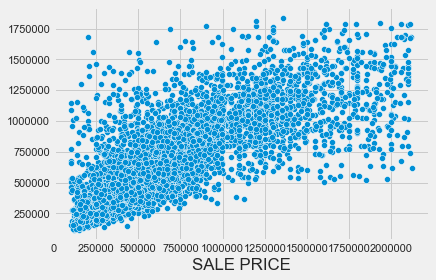

In [10]:
%%time
model1 = show_scores(RandomForestRegressor(random_state=1))

## **3. Feature Engineering**
To improve my model's performance, I'm going to use feature engineering. Feature engineering is the process of creating new features that didn't exist before to improve my models predicting performance. In my process I'm using the following techniques for creating new features:

1. **Mathematical transforms:**
Using arithmetic operations to create new numerical features.
2. **Group Transforms:** Groups transforms aggregate information across multiple rows grouped by some category.


Features I'm thinking about:

* Price per land square feet
* Price per gross square feet
* Median sale price per neighboorhood
* Median sale price per borough
* Median sale price per zipcode


In [11]:
# Creating a new data frame for feature engineering
fe = merged.copy()

# Mathematical transformation
fe['PRICE PER LAND SQFT'] = fe['SALE PRICE'] / fe['LAND SQUARE FEET'] # Ratio price per land square feet
fe['PRICE PER GROSS SQFT'] = fe['SALE PRICE'] / fe['GROSS SQUARE FEET'] # Ratio per gross square feet

# Group Transforms
fe['MEDIAN SALE PRICE NEIGHBORHOOD'] = fe.groupby('NEIGHBORHOOD')['SALE PRICE'].transform('median') # Median sale price per neighborhood
fe['MEDIAN SALE PRICE BOROUGH'] = fe.groupby('BOROUGH')['SALE PRICE'].transform('median') # Median sale price per borough
fe['MEDIAN SALE PRICE ZIP CODE'] = fe.groupby('ZIP CODE')['SALE PRICE'].transform('median') # Median sale price per zipcode

In [12]:
fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41070 entries, 0 to 41069
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         41070 non-null  int64  
 1   NEIGHBORHOOD                    41070 non-null  object 
 2   BUILDING CLASS CATEGORY         41070 non-null  object 
 3   TAX CLASS AT PRESENT            41070 non-null  object 
 4   BUILDING CLASS AT PRESENT       41070 non-null  object 
 5   ADDRESS                         41070 non-null  object 
 6   ZIP CODE                        41070 non-null  int64  
 7   RESIDENTIAL UNITS               41070 non-null  int64  
 8   COMMERCIAL UNITS                41070 non-null  int64  
 9   TOTAL UNITS                     41070 non-null  int64  
 10  LAND SQUARE FEET                25313 non-null  float64
 11  GROSS SQUARE FEET               25180 non-null  float64
 12  YEAR BUILT                      

#### **Modelling again**

In [13]:
# Creating a copy of the dataframe
fe_copy = fe.copy()
# Splitting the data into X &y
X = fe_copy.drop(['ADDRESS', 'SALE PRICE'], axis=1) # Dropping some irrelevant columns and the target
y = fe_copy['SALE PRICE']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1) # 15% for test data

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.175, random_state=1) # ~15% for validation data


In [15]:
# Selecting categorical columns
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_val = X_val[my_cols].copy()
X_test = X_test[my_cols].copy()

In [16]:
# Preprocessing the numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing the categorical data
categorical_transformer = Pipeline(steps=[
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle the preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [17]:
def show_scores(model):
  # Bundle the transformer and the model together
  my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
  # Fitting the data
  my_pipeline.fit(X_train, y_train)

  # Creating predictions for both train and test
  train_preds = my_pipeline.predict(X_train)
  val_preds = my_pipeline.predict(X_val)

  # Use the metrics to evaluate on train and test
  scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
            'Validation MAE': mean_absolute_error(y_val, val_preds),
            'Training MSE': mean_squared_error(y_train, train_preds),
            'Validation MSE': mean_squared_error(y_val, val_preds),
            'Training R2': r2_score(y_train, train_preds),
            'Validation R2': r2_score(y_val, val_preds)}
  
  sns.scatterplot(y_val, val_preds)
  #sns.distplot((y_val - val_preds))

  return scores

CPU times: user 4min 11s, sys: 311 ms, total: 4min 11s
Wall time: 4min 11s


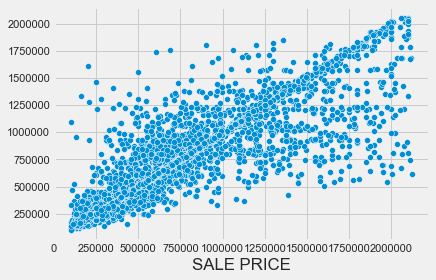

In [18]:
%%time
model2 = show_scores(RandomForestRegressor(random_state=1))

## **4. Compare results**
To compare the results, I'm taking a look at the performance on the validation data. The reason for doing this is because my model hasn't seen this data and  which is very important to create reliable results on data it hasn't seen before.

In [19]:
print(model1)
print(model2)

{'Training MAE': 101926.81705020854, 'Validation MAE': 175843.14462567272, 'Training MSE': 28848468452.54844, 'Validation MSE': 72489749221.75926, 'Training R2': 0.8338021883629976, 'Validation R2': 0.5892693590084508}
{'Training MAE': 64690.59552603898, 'Validation MAE': 83436.30842574796, 'Training MSE': 23153165812.83331, 'Validation MSE': 38460811832.98338, 'Training R2': 0.8666131792441263, 'Validation R2': 0.7820790654290907}


As you can see, the results are very different. The first model that received the normal data without the extra features and performed much worse in comparison with the model that got the extra features. Due feature engineering, the R2 on model 2 improved almost with 20%. The MAE on the validation set from model 2 improved also a lot with 48% which is ~ $92.400,00 .

One last thing I would like to see if which features were imporant and decisive. I'm using a the library eli5 to figure that out. Because I trained my models normally in the function above, I have to use some code outside the function before I can look into the feature importance.

In [20]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', RandomForestRegressor(random_state=1))
                     ])
# Fitting the data
my_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0),
                                                  ['BOROUGH', 'ZIP CODE',
                                                   'RESIDENTIAL UNITS',
                                                   'COMMERCIAL UNITS',
   

In [27]:
# Importing library for feature Importance
import eli5

In [28]:
# Creating a list with the columns from the onehot encoder
onehot_cols = my_pipeline['preprocessor'].transformers_[1][1]['onehot']\
                   .get_feature_names(categorical_cols)

In [29]:
# Creating a list where I'm putting the features from the onehotencoder and numerical together
numeric_features_list = list(numerical_cols)
numeric_features_list.extend(onehot_cols)

eli5.explain_weights(my_pipeline.named_steps['model'], top=10, feature_names=numeric_features_list)

Weight,Feature
0.2965 ± 0.1542,MEDIAN SALE PRICE NEIGHBORHOOD
0.2546 ± 0.0316,PRICE PER LAND SQFT
0.1520 ± 0.0182,LAND SQUARE FEET
0.0770 ± 0.0073,YEAR BUILT
0.0660 ± 0.1434,MEDIAN SALE PRICE ZIP CODE
0.0288 ± 0.0119,ZIP CODE
0.0149 ± 0.0178,TOTAL UNITS
0.0146 ± 0.0286,PRICE PER GROSS SQFT
0.0100 ± 0.0272,BUILDING CLASS AT TIME OF SALE_R4
0.0093 ± 0.0267,BUILDING CLASS CATEGORY_13 CONDOS - ELEVATOR APARTMENTS


As you can see, there are 3 features in the top 5 that were custom made by using feature engineering. The first one which was also made by doing feature engineering was the most relevant feature for predicting property prices in NYC. Overall in the top 10, 4 of those features were custom made. This was the end of my project, I hope you enjoyed it!